# Solutions 08

**Due:** 2022-05-03 (Tue), 11:59 PM, as a Jupyter notebook (with related files) submitted via your repo in the course GitHub organization.  Use the solutions template notebook, and **be sure not to modify the subproblem cells** in your solution file.  This assignment is **mandatory**.

***Note that Problem 2 is for 5780 students only.***

### Collaboration disclosure

(See the [`CourseInfo`](https://github.com/CU-BDA-2022/CourseInfo) repo's `README` file for a description of what's expected here. You may leave this cell unmodified if you worked entirely alone on this assignment. Collaboration is encouraged, following the guidelines in the `README`.)

## Accompanying scripts and/or notebooks:

myscript.py **<-- EDIT identifying any accompanying scripts**

In [1]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

## 1. Linear regression and global warming

### Note:  This exercise does not comprise a serious scientific analysis of global warming data!

This exercise is meant to give you some experience with both linear regression and Stan, and to help you gain some insight into issues, both subtle and not-so-subtle, that arise in trying to predict the behavior of a complex system using *phenomenological models* (i.e., not physical or first-principles models; see [Phenomenological model - Wikipedia](https://en.wikipedia.org/wiki/Phenomenological_model)).

A Python module, implemented in `climate_helpers.py`, accompanies this assignment; it includes both code and data you'll use for your solutions.  Also, the StanFitter module, `stanfitter.py`, which you've encountered earlier, accompanies this assignment.

In [2]:
from climate_helpers import giss_temp_data, years, dTs, MonomialBasis, ChebyshevBasis
from stanfitter import StanFitter

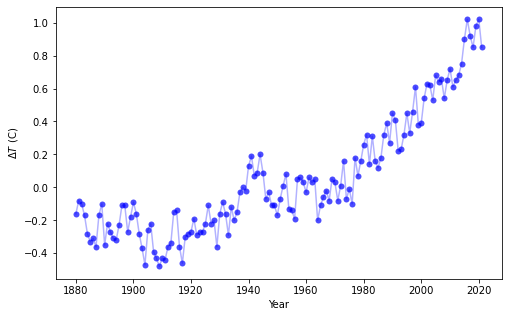

In [3]:
temp_fig = figure(figsize=(8,5))
temp_ax = axes()
plot(years, dTs, 'b-', alpha=.3)
# plot(years, dTs, ls='None', marker='o', ms=8, mfc='b', mew=0, alpha=.7)
plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
xlabel('Year')
ylabel(r'$\Delta T$ (C)');

In [4]:
# Extended array of years, including prediction interval:
xyears = arange(years[0], 2051.)

In [5]:
# 5th-degree bases with zero-mean priors, sig=2:
deg = 5  # number of terms = deg + 1
mono = MonomialBasis(deg, xyears, sigma=2.)
cheb = ChebyshevBasis(deg, xyears, sigma=2.)

### Problem 1.1 (1 point):

> * Make a 2-panel plot (use `figure(figsize=(...))` and `subplot(...)` with appropriate arguments), showing 50 samples from each of the two degree 5 bases just defined.  Be sure to title the subplots, identifying the cases.  If done correctly, the two plots should look quite different.
> * From the perspective of an investigator wanting to be noncommital about global temperature trends a priori (i.e., allowing the greatest variety of possible shapes a priori), which basis/prior combination appears to be the better one to you?  Briefly explain why.

### Problem 1.2 (1 point):

> * Below you'll find incomplete Stan code for a linear regression model for the global warming data.  The `model` section is empty.  Complete it, consulting the [Stan Modeling Language User's Guide](http://mc-stan.org/users/documentation/index.html) for how to build regression models in Stan (see Section 1.1, on linear regression; note that the basis functions include the "intercept" term discussed at the end of that section).  The model code should have three main ingredients:
    * Priors for the coefficients (set in a loop over the coefficients in the `beta` vector); use zero-mean normal priors with standard deviation $= 2$, as used for your prior sample plots.
    * A prior for $\sigma$, the conditional standard deviation for the temperature measurements.  Adopt an exponential prior with a mean of 2., a broad prior compared to the visual scale of the temperature fluctuations over short time spans.
    * A sampling distribution (defining the likelihood function) for the temperature change data vector.  Do this using Stan's implicit looping capability (i.e., write it without using a `for` loop; this is discussed in that same section).
> * Compile the model with StanFitter.

Note that since the basis gets passed in as "data" (including the number of coefficients) *you only need a single fitter instance* to fit multiple models with different bases and degrees.  You'll only have to alter the code and recompile it if you change the priors (other than changing the bases).

In [6]:
# Stan code for linear regression:
lin_regn_code = """
data {
    int<lower=0> n; // number of times sampled
    int<lower=0> m; // number of coeff = deg + 1
    matrix[n,m] basis; // basis funcs, aka design matrix
    vector[n] dT; // temp change
}

parameters {
    vector[m] beta;  // coeficients
    real<lower=0> sigma;  // noise scale
}

model {
    // FILL IN HERE; SEE STAN MANUAL
}
"""

# Uncomment to compile finished code:
# fitter = StanFitter(lin_regn_code, name='lin_regn')

### Problem 1.3 (2 points):

> * Write a function, `fit_model`, building on the stub provided below, that does the following, producing a single plot:
> * Build a basis of specified type and degree.
>  * Fit the data, obtaining the posterior mode and posterior samples.
>  * Plot the data.
>  * Plot 40 polynomials sampled from the posterior, as thin curves with colors automatically chose by matplotlib.  Use a small `alpha` opacity (say, .2), so curves remain visible despite overlap.
>  * Plot a thick dashed curve showing the polynomial corresponding to the mode.
>  * Plot a single error bar somewhere along the curve displaying the value of $\sigma$ at the mode.
>  * Return the (MCMC) fit results and mode.

Your work for this subproblem should all be in the next single cell; you'll *use* the function below.

In [7]:
def fit_model(fitter, Poly, deg, csig, n_iter=1000, n_chains=4,
              years=years, dTs=dTs, xyears=xyears):
    """
    Fit the data and summarize results.

    Parameters
    ----------
    
    fitter : StanFitter instance
    
    Poly : Polynomial basis class
    
    deg : int
        Degree of polynomial to fit

    csig : float
        Coeffient prior standard deviation

    n_iter, n_chains : int
        The number of iterations per chain, and number of chains, for Stan fits

    years, dTs, xyears : float arrays
        Data (years, dTs) and extended years covering data and prediction
        interval (xyears)
    """
    nbeta = deg + 1  # number of coefs
    # Build a basis over the fit+prediction interval.
    poly = Poly(deg, xyears, sigma=csig)
    # For fitting the data, pull out the part spanning years.
    data_basis = poly.basis[:len(years),:]
    # Data dict for Stan:
    data = dict(n=len(years), m=nbeta, basis=data_basis, dT=dTs)

    # Do the fit, MCMC and optimization:
    fitter.set_data(data)
    fit = fitter.sample(n_iter, n_chains)
    mode = fitter.mode()

    # Plot dTs:
    temp_fig = figure()
    temp_ax = axes()
    plot(years, dTs, 'b-', alpha=.3)
    plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
    xlabel('Year')
    ylabel(r'$\Delta T$ (C)')
    xlim(xyears[0], xyears[-1])
    ylim(-1.5, 1.5)

    # MUCH MORE HERE
    
    return fit, mode
    

### Problem 1.4 (2 points):

> * Use `fit_model` to use both the monomial and Cheybshev bases to fit **4th degree** polynomials to the data, with the coefficient priors having standard deviation `csig=2.0`.  The notebook should execute one of the `fit_model` calls, but you should execute the other in a script, just including the plot in the notebook.  Use the returned `fit` objects to assure yourself of convergence and good mixing.  You need not provide plots and printouts in the notebook for this, but you should include a Markdown cell below with a *brief* description of what you did regarding output diagnostics.
> * Briefly comment on what the two fits tell you about sensitivity of the results to the prior over polynomials.

### Problem 1.5 (2 points):

> * Use `fit_model` to use both monomial and Cheybshev bases to fit **5th degree** polynomials to the data, with a prior standard deviation `csig=2.`.  Show the plots you produce in the notebook, clearly identified (the code should be in a separate script).
> * In words, compare the 4th degree and 5th degree results, and briefly comment on the implications of the difference for using phenomenological vs. physical models to make predictions from climate data.

### Problem 2.1 (2 points):

Demonstrate inference of the width of a fixed-location uniform distribution, with width $\Delta$ and location $m=0$ on the $x$ axis, with $m$ denoting its known midpoint, and $\Delta$ unknown.

> * Write down the likelihood function for $\Delta$ given the locations $\{x_i\}$ of $N$ samples.
> * Adopt a log-flat (i.e., scale-invariant) prior for $\Delta$, i.e., $\pi(\Delta)\propto 1/\Delta$, and compute the posterior for $\Delta$ (analytically!).
> * How many samples are required for the posterior to be proper?  (*Comment:* This bears on the appropriateness of the prior as an expression of ignorance of the width. That is, if there is a minimum sample size for which it makes sense to estimate a parameter, a reasonable requirement for an "uniformative" prior is that it give a proper posterior only when that minnimum sample size is attained.)
> * Find a closed-form expression for the posterior mean for $\Delta$.

### Problem 2.2 (2 points):

Suppose you have a digital clock that displays the time to the minute, which runs at an accurate rate but which is not set to perfectly match [official US time](http://www.time.gov/).  After hearing (official) time announcements on the radio over the course of a few days (public radio, of course!), announced with 1-minute precision, you realize your clock is set slightly late, by an amount $\delta t$ less than 1 minute; that is, you sometimes hear the announced time matching your clock's displayed time, but you sometimes hear it announced earlier.
> Suppose the radio announcers announce the time at moments chosen uniformly at random.  If you hear $N$ total announcements, $n$ of them matching your clock's displayed time, what is the posterior PDF for your clock's time lag, $\delta t$? Choose a prior yourself, but motivate your choice.